In [1]:
import pandas as pd

from global_constants import *

from os.path import join

import csv

from scipy.spatial.distance import cdist

from sklearn.neural_network import MLPClassifier

import matplotlib.image as mpimg

from sklearn import metrics
from sklearn.model_selection import train_test_split

import pickle

from matplotlib import pyplot as plt
%pylab inline

# constants
minimum_number_of_labels = 31

Populating the interactive namespace from numpy and matplotlib


In [4]:
def get_normalised_prob(prediction_weights):
    normalizing_factor = sum(prediction_weights)
    return np.array(prediction_weights)/normalizing_factor

def normalize_rows(matrix, minimum_number_of_labels, binary_predictions=None):
    matrix_argsort = matrix.argsort()
    
    # Iterate over i
    for i in range(len(matrix)):

        # Decide number to roll with
        number_to_use = minimum_number_of_labels
        
        # Zero out other values
        for k in range(len(matrix[i])):
            matrix[i][k] = 0 if k not in matrix_argsort[i][-number_to_use:] else matrix[i][k]

        # normalize
        matrix[i] = get_normalised_prob(matrix[i])

        # Sanity Check
        # print(sum(matrix[i]))
        
    return matrix

def get_ordered_data_frame(csv_path, mode='train', number_of_train_features=1000, tag="fc"):
    data_frame = pd.read_csv(join(data_path, csv_path), names=["name"] + [tag + str(k) for k in range(number_of_train_features)])
    data_frame["file_name_index"] = pd.to_numeric(data_frame.name.str.extract("((?<=[images_" + mode + "\/])\d*(?=\.))", expand=False))
    data_frame.sort_values('file_name_index', inplace=True)
    return data_frame.drop(["name"], axis=1)

In [5]:
train_fc_data = get_ordered_data_frame('features_train/features_resnet1000_train.csv', number_of_train_features=1000, tag="fc")
train_intermediate_data = get_ordered_data_frame('features_train/features_resnet1000intermediate_train.csv', number_of_train_features=2048, tag="pl")

combined_train_net_data = train_intermediate_data.join(train_fc_data.set_index('file_name_index'), lsuffix='_caller', rsuffix='_other', on='file_name_index')

test_fc_data = get_ordered_data_frame('features_test/features_resnet1000_test.csv', "test", number_of_train_features=1000, tag="fc")     
test_intermediate_data = get_ordered_data_frame('features_test/features_resnet1000intermediate_test.csv', "test", number_of_train_features=2048, tag="pl")     

combined_test_net_data = test_intermediate_data.join(test_fc_data.set_index('file_name_index'), lsuffix='_caller', rsuffix='_other', on='file_name_index')

# X = train_fc_data.drop(["file_name_index"], axis=1).values
# X_Test = test_fc_data.drop(["file_name_index"], axis=1).values
# X = combined_train_net_data.drop(["file_name_index"], axis=1).values
# X_Test = combined_test_net_data.drop(["file_name_index"], axis=1).values

In [6]:
better_tag_data = pd.read_csv('better_train_5_tags_nouns.csv')

In [7]:
X_Train, X_Val, Y_train, Y_Val = train_test_split(train_intermediate_data, better_tag_data.values, train_size=0.8)

gt_files = X_Val.file_name_index.values
better_tag_val_data = Y_Val.copy()

X_Train = X_Train.drop(["file_name_index"], axis=1).values
X_Val = X_Val.drop(["file_name_index"], axis=1).values
Y_train[Y_train != 0] = 1
Y_Val[Y_Val != 0] = 1

In [8]:
X_Test = test_intermediate_data.drop(["file_name_index"], axis=1).values

In [9]:
better_tag_test_data = pd.read_csv('better_test_5_tags_nouns.csv')
# better_tag_test_data = normalize_rows(better_tag_test_data.as_matrix(), minimum_number_of_labels)

In [10]:
classifier = MLPClassifier(hidden_layer_sizes=(500), verbose=True, max_iter=30, warm_start=True)

In [11]:
classifier.fit(X_Train, Y_train)

Iteration 1, loss = 352.89836950
Iteration 2, loss = 74.00914628
Iteration 3, loss = 60.26886699
Iteration 4, loss = 52.75763064
Iteration 5, loss = 48.25535674
Iteration 6, loss = 45.52898206
Iteration 7, loss = 43.65839491
Iteration 8, loss = 42.29319348
Iteration 9, loss = 41.25529091
Iteration 10, loss = 40.36361430
Iteration 11, loss = 39.58862850
Iteration 12, loss = 38.88132637
Iteration 13, loss = 38.20511785
Iteration 14, loss = 37.60771561
Iteration 15, loss = 37.07788070
Iteration 16, loss = 36.53074484
Iteration 17, loss = 35.99037773
Iteration 18, loss = 35.48217958
Iteration 19, loss = 34.98199351
Iteration 20, loss = 34.52778568
Iteration 21, loss = 34.05358369
Iteration 22, loss = 33.59615256
Iteration 23, loss = 33.13771619
Iteration 24, loss = 32.68965078
Iteration 25, loss = 32.27401372
Iteration 26, loss = 31.87371295
Iteration 27, loss = 31.45065213
Iteration 28, loss = 31.00563645
Iteration 29, loss = 30.58841371
Iteration 30, loss = 30.20039838


/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=500, learning_rate='constant',
       learning_rate_init=0.001, max_iter=30, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=True, warm_start=True)

In [457]:
# pickle.dump(classifier, open("best_classifier.pkl", "wb"))

In [67]:
def get_accuracy_on_set(X_Val, Y_val_proba, better_tag_val_data, gt_files):

    Y_val_proba = classifier.predict_proba(X_Val)
    temp_simi = cdist(better_tag_val_data, Y_val_proba, metric='cosine')

    score = 0.0
    for i_check in range(len(X_Val)):
        pred_list = list(temp_simi[i_check].argsort()[:20])

        k = [gt_files[i] for i in pred_list]
        if gt_files[i_check] in k:
            score += float(20 - k.index(gt_files[i_check]))/20

    return score/2000

temp_simi, accuracy = get_accuracy_on_set(X_Val, Y_val_proba, better_tag_val_data, gt_files)
print(accuracy)

0.5248250000000004


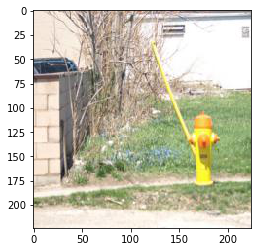

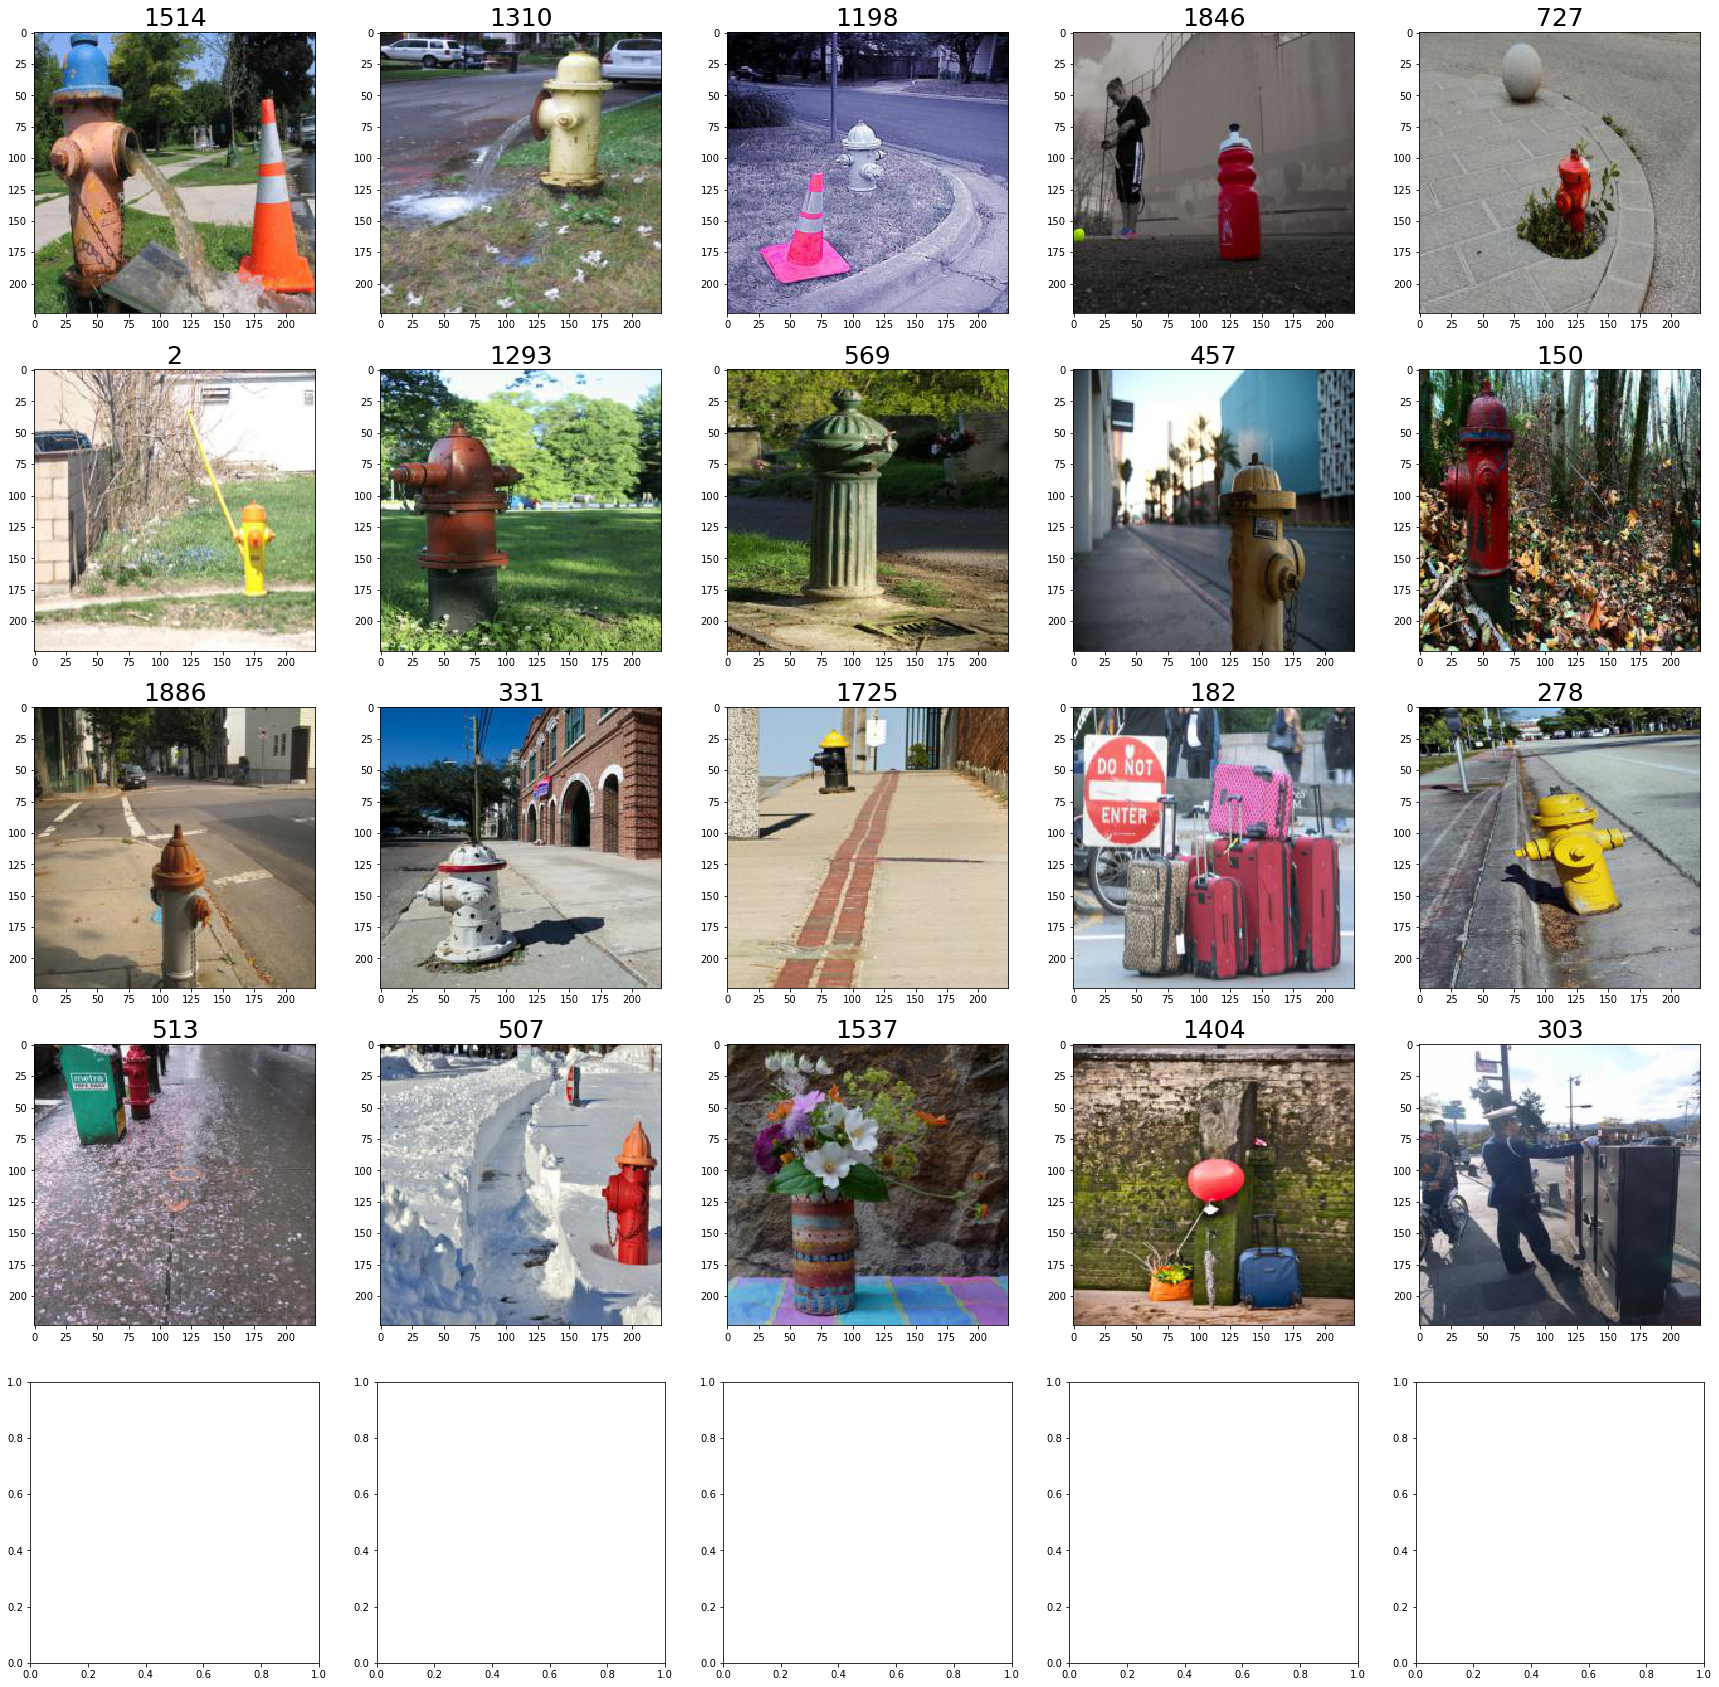

In [63]:
i_check = 2

img=mpimg.imread('data/images_train/' + str(gt_files[i_check]) + ".jpg")
plt.imshow(img)

row, col = 5,5
pred_list = list(temp_simi[i_check].argsort()[:20])

f, ax = plt.subplots(nrows=row, ncols=col, figsize=(30,30))
for index, image_1 in enumerate(pred_list):
    if index == row*col:
        break
    img=mpimg.imread('data/images_train/' + str(gt_files[image_1]) + ".jpg")
    

    ax[int(index/row), index%col].imshow(img)
    ax[int(index/row), index%col].set_title(image_1, fontsize=25)

In [423]:
Y_test_proba = classifier.predict_proba(X_Test)

In [418]:
Y_test_proba = normalize_rows(classifier.predict_proba(X_Test), minimum_number_of_labels)

In [427]:
# Y_test = classifier.predict(X_Test)

Y_test_proba_1 = normalize_rows(Y_test_proba.copy(), 11)

Y_test_proba_2 = normalize_rows(Y_test_proba_1.copy(), 7)

Y_test_proba_3 = normalize_rows(Y_test_proba_2.copy(), 5)

Y_test_proba_4 = normalize_rows(Y_test_proba_3.copy(), 2)

In [428]:
simi_1 = cdist(better_tag_test_data, Y_test_proba, metric='cosine')

simi_2 = cdist(better_tag_test_data, Y_test_proba_1, metric='cosine')

simi_3 = cdist(better_tag_test_data, Y_test_proba_2, metric='cosine')

simi_4 = cdist(better_tag_test_data, Y_test_proba_3, metric='cosine')

simi_5 = cdist(better_tag_test_data, Y_test_proba_4, metric='cosine')

In [437]:
temp_simi = cdist(better_tag_test_data, Y_test_proba, metric='cosine')
rows=[['Descritpion_ID', 'Top_20_Image_IDs']]
for i in range(len(better_tag_test_data)):
    buffer1=[]
    buffer1=temp_simi[i].argsort()[:20]
    rows.append([str(i) + ".txt", " ".join([str(value) + ".jpg" for value in buffer1])])
csv.writer(open("submission_try.csv", "w")).writerows(rows)

In [535]:
k = pd.DataFrame(cdist(better_tag_test_data, Y_test_proba, metric='cosine'))
k.to_csv("simi.csv")

In [444]:
# simi=cdist(better_tag_test_data, Y_test_proba, metric='euclidean')
simi = simi_1 + 1/2*(simi_2 + simi_3 + simi_4 + simi_5)

In [445]:
rows=[['Descritpion_ID', 'Top_20_Image_IDs']]
for i in range(len(better_tag_test_data)):
    buffer1=[]
    buffer1=simi[i].argsort()[:20]
    rows.append([str(i) + ".txt", " ".join([str(value) + ".jpg" for value in buffer1])])
csv.writer(open("submission_try.csv", "w")).writerows(rows)

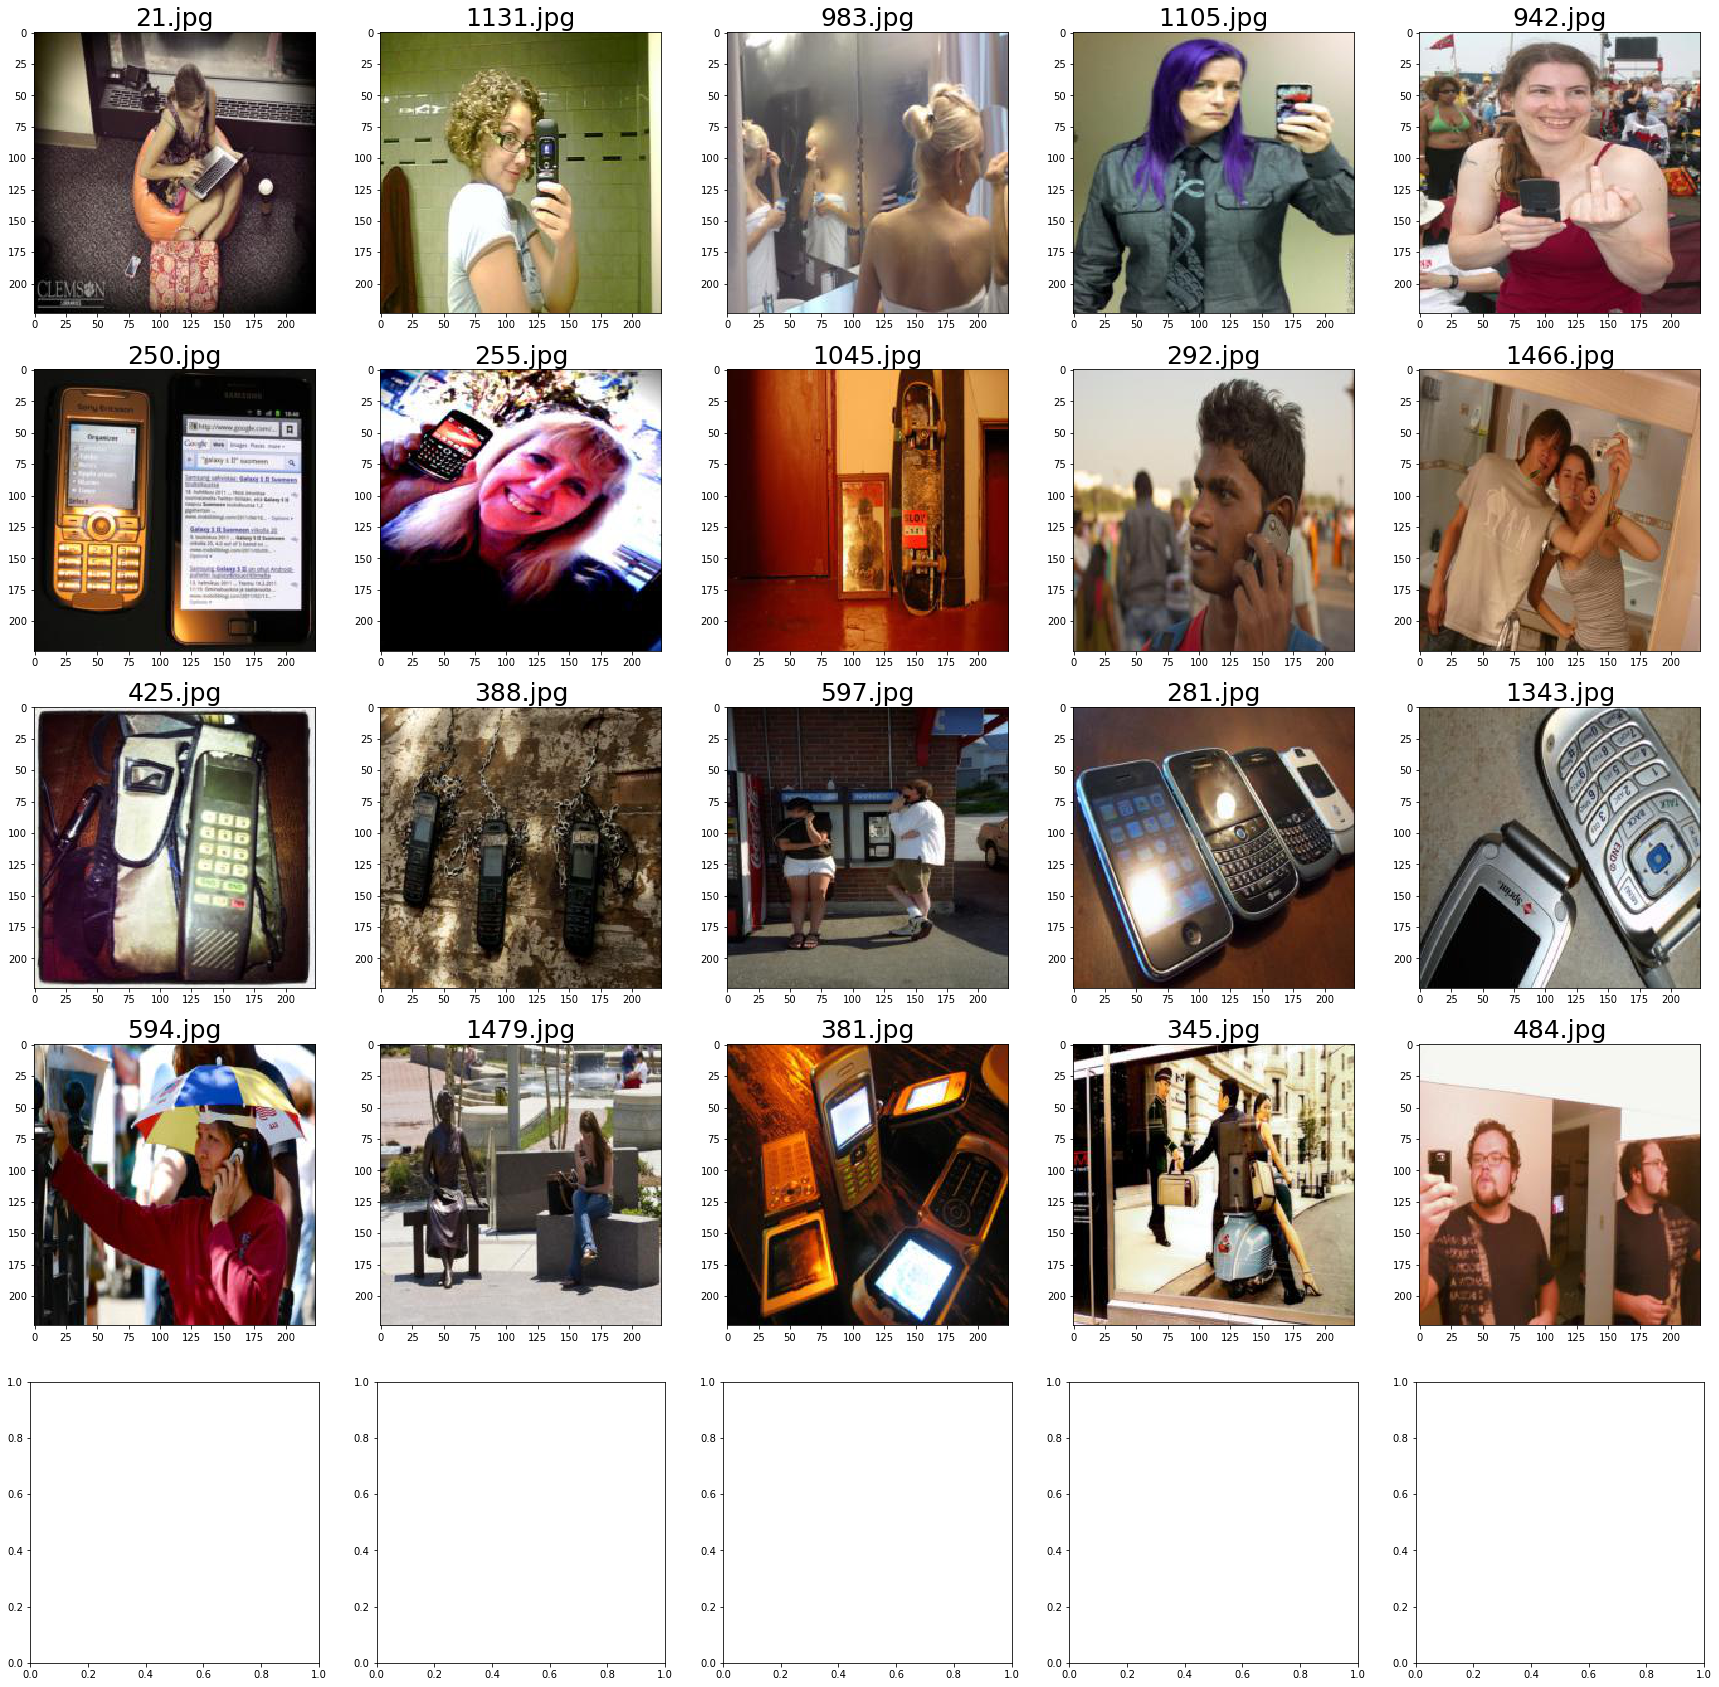

In [447]:
d_check=0

output_statement = rows[d_check + 1][1]

row, col = 5,5

f, ax = plt.subplots(nrows=row, ncols=col, figsize=(30,30))
for index, image_1 in enumerate(output_statement.split()):
    if index == row*col:
        break
    img=mpimg.imread('data/images_test/' + image_1)
    

    ax[int(index/row), index%col].imshow(img)
    ax[int(index/row), index%col].set_title(image_1, fontsize=25)